In [23]:
# dimensionality reduction using RFECV
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.feature_selection import RFECV
from scipy.io import arff
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [24]:
# read data
data = arff.loadarff('F:\Thesis\MicroArray dataset\Binary\Brain Tumor\BrainTumor_CNS.arff')
df = pd.DataFrame(data[0])

# check data
df.head()

# find if there is any missing value
df.isnull().sum().sum()

0

In [33]:
le = LabelEncoder()
df['CLASS'] = le.fit_transform(df['CLASS'])

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [34]:
# standardize the data
scaler = StandardScaler()
std_X = scaler.fit_transform(X)
X = pd.DataFrame(std_X, columns=X.columns)

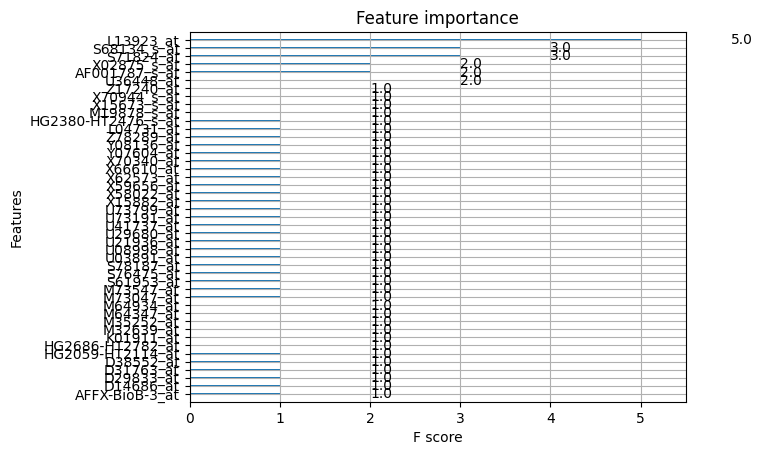

In [35]:
# do a ranking with XGBoost and take the top 200 features
from xgboost import XGBClassifier
from xgboost import plot_importance

model = XGBClassifier()
model.fit(X, y)
plot_importance(model)
plt.show()

# get the feature importance
importance = model.feature_importances_
importance = pd.DataFrame(importance, index=X.columns, columns=["Importance"])
importance = importance.sort_values(by=["Importance"], ascending=False)
importance = importance.head(200)

# get the top 200 features
X = X[importance.index]

In [36]:
cv = StratifiedKFold(10, shuffle=True, random_state=123)
# feature extraction
model = LogisticRegression()
rfecv = RFECV(estimator=model, min_features_to_select=50)
fit = rfecv.fit(X, y)

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 52
Selected Features: [ True  True False  True False  True  True  True  True False False  True
  True  True  True False  True False  True  True False  True  True False
 False False  True  True  True False  True False False  True False  True
  True False False False  True  True  True  True False False False False
  True False  True  True  True  True False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False  True False
  True False False False False False False False  True False False False
 False False False  True False  True  True False  True False  True False
 False False  True False False False False False False False  True False
 False False False False False False False  True False False  True False
 False False False False False  True  True False False False False False
 False False False False False False False False False False  True False
 False False Fa

In [37]:
mask = fit.support_

X_new = X.loc[:, mask]
print(X_new.head())

   X59656_at  S71824_at  D29833_at  M73547_at  M35252_at  X02875_s_at  \
0   0.514523  -1.073619   0.056421  -0.547599  -0.888707    -0.894661   
1  -0.841712  -0.722787   0.143782   0.085788   0.193425    -0.419720   
2   0.022036  -0.382918  -0.478667  -0.937588  -0.230018    -0.792887   
3  -0.716695  -0.799531   0.689791  -1.071734  -0.543680     1.536585   
4  -1.057648  -0.757870  -0.249344  -1.304068   1.150092     3.515505   

   U29680_at  AF001787_s_at  HG2059-HT2114_at  L13923_at  ...  X86570_at  \
0  -0.282548       0.180866         -0.766604   0.251517  ...  -0.547990   
1   1.118201      -0.167441          0.279090   0.366964  ...  -0.293405   
2  -0.301737       0.159097         -1.020885  -0.383439  ...  -0.661982   
3   0.120407      -0.134788         -0.686606  -0.426731  ...  -0.677182   
4   0.945506       1.715594         -1.543732  -0.531355  ...  -0.111016   

   X85785_rna1_at  X85740_at  X91103_at  X96698_at  X96401_at  X95654_at  \
0       -1.225686   0.529147

In [38]:
# run a voting classifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

clf1 = LogisticRegression(random_state=1)
clf2 = DecisionTreeClassifier(random_state=1)
clf3 = SVC(random_state=1)
clf4 = RandomForestClassifier(random_state=1)

eclf = VotingClassifier(estimators=[('lr', clf1), ('dt', clf2), ('svc', clf3), ('rf', clf4)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, eclf], ['Logistic Regression', 'Decision Tree', 'SVM', 'Random Forest', 'Ensemble']):
    scores = cross_val_score(clf, X_new, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.98 (+/- 0.05) [Logistic Regression]
Accuracy: 0.67 (+/- 0.21) [Decision Tree]
Accuracy: 0.93 (+/- 0.11) [SVM]
Accuracy: 0.88 (+/- 0.11) [Random Forest]
Accuracy: 0.90 (+/- 0.11) [Ensemble]


In [39]:
# print("Feature Ranking: %s" % fit.ranking_)

# print the selected features
selected_features = X.columns[fit.support_]
print(selected_features)

Index(['X59656_at', 'S71824_at', 'D29833_at', 'M73547_at', 'M35252_at',
       'X02875_s_at', 'U29680_at', 'AF001787_s_at', 'HG2059-HT2114_at',
       'L13923_at', 'Z17240_at', 'M19878_s_at', 'U41737_at',
       'HG2686-HT2782_at', 'M64347_at', 'Y07604_at', 'D31763_at', 'D38552_at',
       'U21936_at', 'S76475_at', 'X62573_at', 'D14686_at', 'U08998_at',
       'X15882_at', 'U73191_at', 'X58022_at', 'K01911_at', 'X87241_at',
       'X87852_at', 'X87843_at', 'X87237_at', 'X87767_at', 'X90568_at',
       'AFFX-BioB-5_at', 'X85133_at', 'X84194_at', 'X83573_at', 'X83543_at',
       'X83441_at', 'X83412_at', 'X83368_at', 'X86816_at', 'X86570_at',
       'X85785_rna1_at', 'X85740_at', 'X91103_at', 'X96698_at', 'X96401_at',
       'X95654_at', 'X98176_at', 'X91992_at', 'X92744_at'],
      dtype='object')


In [40]:
# write the selected features in a text file
with open('F:\Thesis\MicroArray dataset\Binary\Brain Tumor\RFECV\selected_features.txt', 'w') as f:
    for item in selected_features:
        f.write("%s\n" % item)